# Regression Tree

## Prepare for modelling

### Import libraries and read data

In [1]:
import pandas as pd 
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import mlflow
from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

from yellowbrick.regressor import ResidualsPlot

In [2]:
# read data
df = pd.read_csv('../data/Featureselection03.csv')
df.head()

,EntryDate,AB.FMS.act.tPh,AB.FTS.act.dgC,DDM.AFTCL.act.m,DDM.FWDCL.act.m,DDM.MIDPS.act.m,DDM.MIDSB.act.m,HFO.GME.act.nodim,ME.EFF.act.PRC,ME.FMS.act.tPh,...,Heading_Dir_deg_daily,True_Wind_Speed_mPs_daily,True_Wind_Dir_deg_daily,Wave_Height_m_daily,True_Wave_Dir_deg_daily,trip_id,Power_EM_predict,DDM.TRIM.act.m,DDM.DRAFT.act.m,DDM.HEEL.act.m
0,2021-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,6.7,109.0,0.5,289.0,1,14579.22,1.021,0.1276,0.2552
1,2021-05-31 00:01:00,0.003108,82.858482,13.309999,14.788999,13.924999,13.587000,1.0,50.766113,3.353553,...,80.0,6.7,109.0,0.5,289.0,2,14579.22,1.021,0.1276,0.2552
2,2021-05-31 00:02:00,0.001970,82.832756,13.444999,14.363999,13.320999,13.378999,1.0,50.982193,3.305582,...,80.0,6.7,109.0,0.5,289.0,2,14579.22,1.021,0.1276,0.2552
3,2021-05-31 00:03:00,0.000000,82.795395,13.381999,14.321000,14.242000,13.584000,1.0,51.326881,3.288588,...,80.0,6.7,109.0,0.5,289.0,2,14579.22,1.021,0.1276,0.2552
4,2021-05-31 00:04:00,0.000000,82.884254,13.365999,14.745000,14.094998,13.596999,1.0,52.311672,3.239272,...,80.0,6.7,109.0,0.5,289.0,2,14579.22,1.021,0.1276,0.2552


In [3]:
# read list with feature importance
data_log = pd.read_csv('../data/Capstone_features_Features.csv')
data_log.head()

,VarName,F_Imp_new,ModelImportance
0,LM1.plc_skewtime.act.s,3,3
1,LM1.plc_skewtime.max.s,3,3
2,LM1.plc_uptime.act.s,3,3
3,LM1.plc_cpuload.avg_5s.PRC,3,3
4,LM1.plc_timeBalance.act.s,3,3


### Create data frame with important features

In [4]:
# create list of important features (feature importance < 3)
list_imp_feat = list(data_log[data_log['ModelImportance'] < 3]['VarName'])
len(list_imp_feat)

18

In [5]:
df_model = df[list_imp_feat].copy()

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           210961 non-null  float64
 1   ME.FTS.act.dgC           210961 non-null  float64
 2   HFO.GME.act.nodim        210961 non-null  float64
 3   V.COG.act.deg            210885 non-null  float64
 4   V.SOG.act.kn             210885 non-null  float64
 5   V.RUA.act.deg            210885 non-null  float64
 6   V.GPSLAT.act.deg         210885 non-null  float64
 7   V.GPSLON.act.deg         210885 non-null  float64
 8   WEA.WDT.act.deg          210814 non-null  float64
 9   WEA.WST.act.mPs          210884 non-null  float64
 10  V.SLPOG.act.PRC          136969 non-null  float64
 11  ME.SFCI.act.gPkWh        136929 non-null  float64
 12  DDM.TRIM.act.m           211679 non-null  float64
 13  DDM.DRAFT.act.m          211679 non-null  float64
 14  pass

### Fill and drop NaN, remove outlier

In [7]:
df_model['V.SLPOG.act.PRC'].fillna(0,inplace=True)
df_model['ME.SFCI.act.gPkWh'].fillna(0,inplace=True)

In [8]:
df_model.dropna(inplace=True)

In [9]:
df_model = df_model[df_model['ME.FMS.act.tPh']<8]

In [10]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180148 entries, 1 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           180148 non-null  float64
 1   ME.FTS.act.dgC           180148 non-null  float64
 2   HFO.GME.act.nodim        180148 non-null  float64
 3   V.COG.act.deg            180148 non-null  float64
 4   V.SOG.act.kn             180148 non-null  float64
 5   V.RUA.act.deg            180148 non-null  float64
 6   V.GPSLAT.act.deg         180148 non-null  float64
 7   V.GPSLON.act.deg         180148 non-null  float64
 8   WEA.WDT.act.deg          180148 non-null  float64
 9   WEA.WST.act.mPs          180148 non-null  float64
 10  V.SLPOG.act.PRC          180148 non-null  float64
 11  ME.SFCI.act.gPkWh        180148 non-null  float64
 12  DDM.TRIM.act.m           180148 non-null  float64
 13  DDM.DRAFT.act.m          180148 non-null  float64
 14  pass

### Check correlations

<AxesSubplot:>

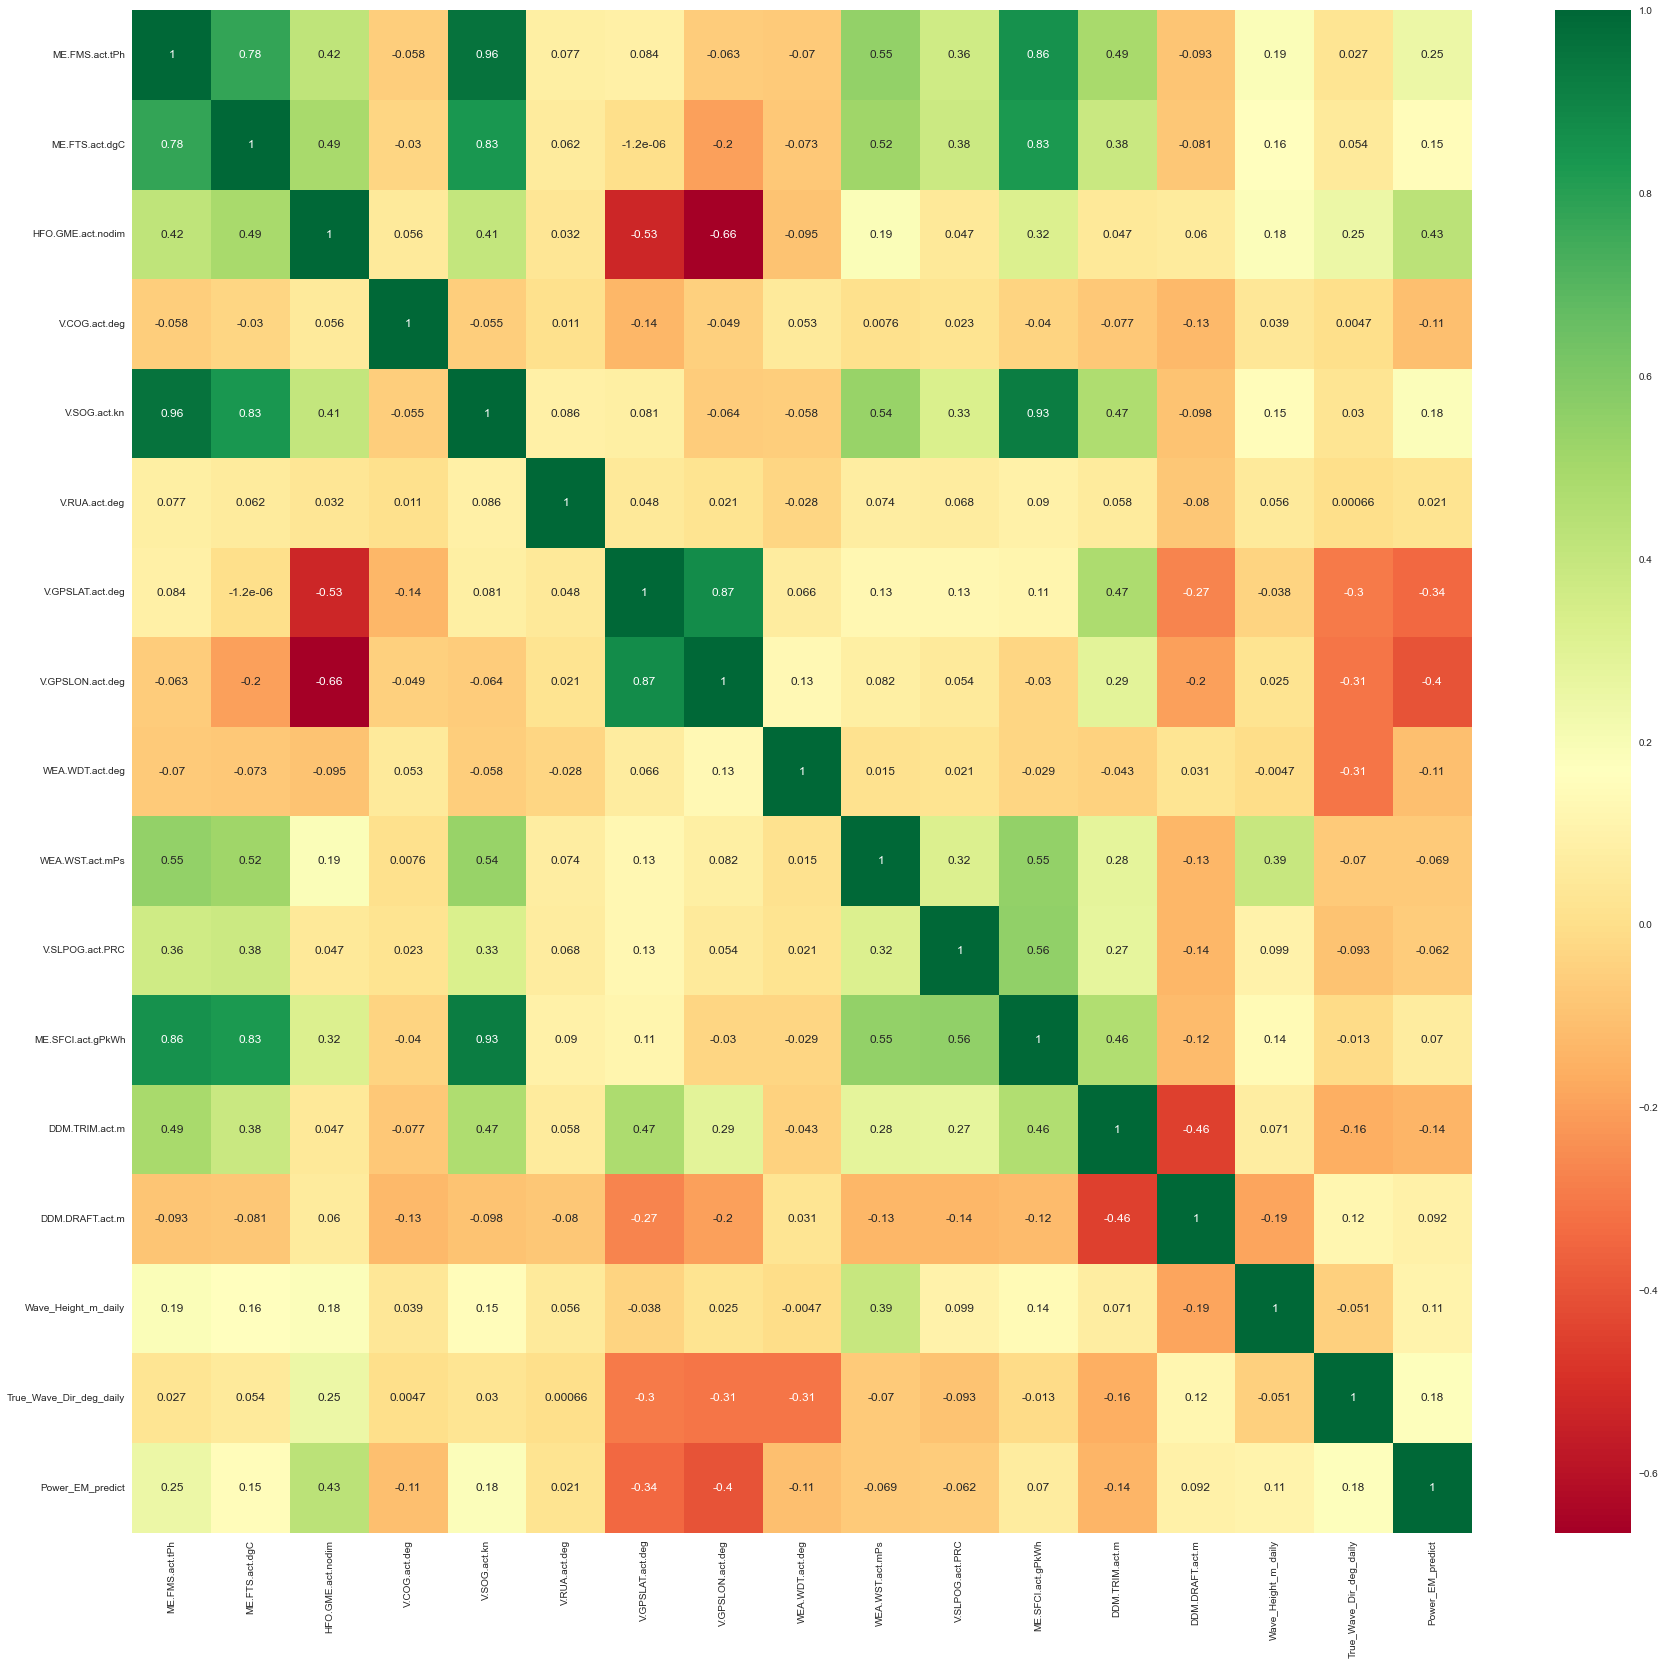

In [11]:
plt.figure(figsize = (30,28))
sns.heatmap(df_model.corr(), annot = True, cmap = 'RdYlGn')

### Define target

In [12]:
X = df_model.drop(['ME.FMS.act.tPh'], axis = 1)
y = df_model['ME.FMS.act.tPh']

### Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = X['passage_type'], test_size = 0.1, random_state = 42)

### Create dummy values for passage type

In [14]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

## Set MLFlow connection

In [134]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run(run_name='DecissionTree') 
run = mlflow.active_run()

## Modelling (max_leaf_nodes=6,max_depth=3)

### Pipeline

In [15]:
tree = make_pipeline(MinMaxScaler(), DecisionTreeRegressor(max_leaf_nodes=6,max_depth=3))

### Fit and predict

In [16]:
tree.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=3, max_leaf_nodes=6))])

In [17]:
y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)

### RMSE

In [18]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.4305139444618942
RMSE test:  0.43645367853562556


### Plot

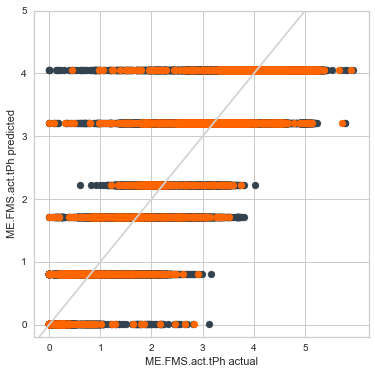

In [20]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
plt.xticks(np.arange(0,6,1));
plt.yticks(np.arange(0,6,1));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");

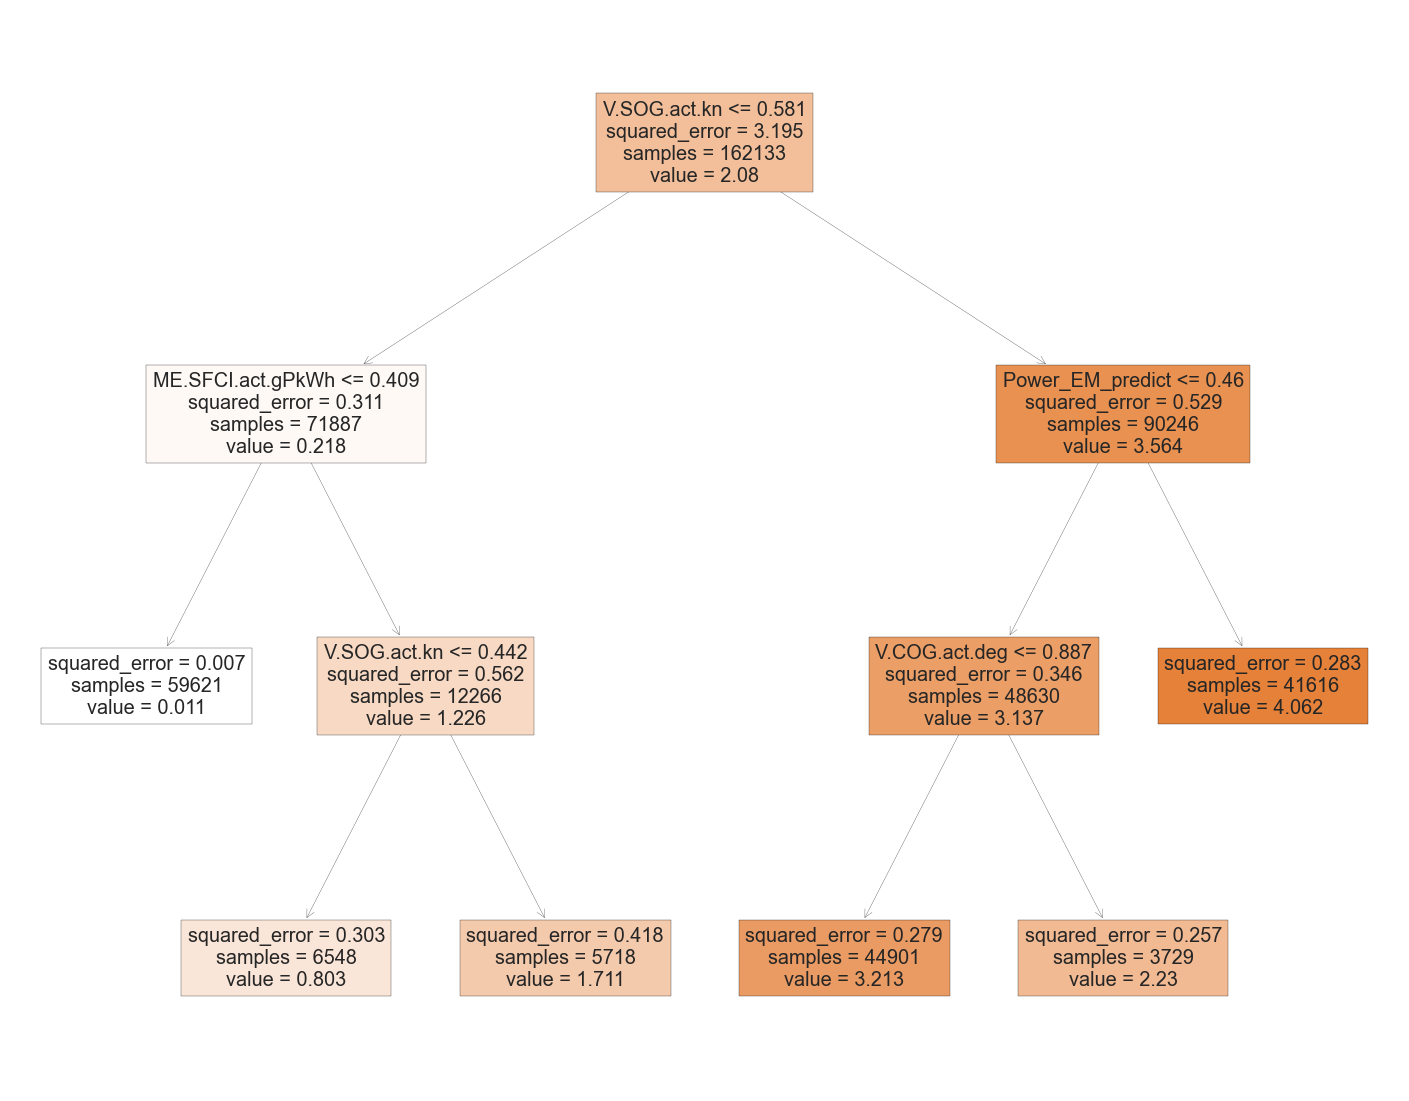

In [21]:
fig = plt.figure(figsize=(25,20))
dectree_plot = plot_tree(tree['decisiontreeregressor'], filled=True, feature_names=X_train.columns.tolist())

### Write to MLFlow

In [ ]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "features drop": 'According to model importance list',
      "max_depth": 3,
      "max_leaf_nodes": 6,
      "csv used": 'Featureselection03.csv',
      "NaN handling": 'V.SLPOG.act.PRC and ME.SFCI.act.gPkWh filled with 0, rest dropped by row',
      'Shape' : df.shape,
      'Scaler' : 'MinMaxScaler'
  }

In [ ]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "RMSE", rmse_train)
mlflow.log_metric("test-" + "RMSE", rmse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

## Modelling (all default)

### Pipeline

In [22]:
tree2 = make_pipeline(MinMaxScaler(), DecisionTreeRegressor(random_state=42))

### Fit and predict

In [23]:
tree2.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [24]:
y_pred = tree2.predict(X_test)
y_pred_train = tree2.predict(X_train)

### RMSE

In [25]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  5.2335864362665766e-11
RMSE test:  0.10048726787274559


### Plot

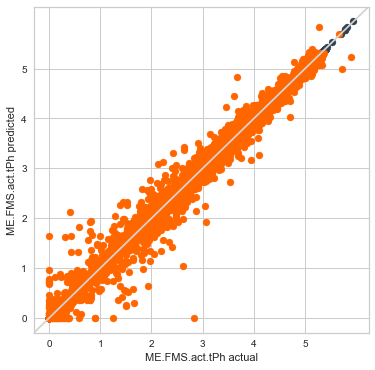

In [27]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
plt.xticks(np.arange(0,6,1));
plt.yticks(np.arange(0,6,1));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");

### Write to MLFlow

In [ ]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "features drop": 'According to model importance list',
      "random_state": 42,
      "csv used": 'Featureselection03.csv',
      "NaN handling": 'V.SLPOG.act.PRC and ME.SFCI.act.gPkWh filled with 0, rest dropped by row',
      'Shape' : df.shape,
      'Scaler' : 'MinMaxScaler'
  }

In [ ]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "RMSE", rmse_train)
mlflow.log_metric("test-" + "RMSE", rmse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

## Modelling (max_depth=10)

### Pipeline

In [28]:
tree3 = make_pipeline(MinMaxScaler(), DecisionTreeRegressor(random_state=42,max_depth=10))

### Fit and predict

In [29]:
tree3.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=10, random_state=42))])

In [30]:
y_pred = tree3.predict(X_test)
y_pred_train = tree3.predict(X_train)

### RMSE

In [31]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.12733491799720184
RMSE test:  0.1393493062723221


### Plot

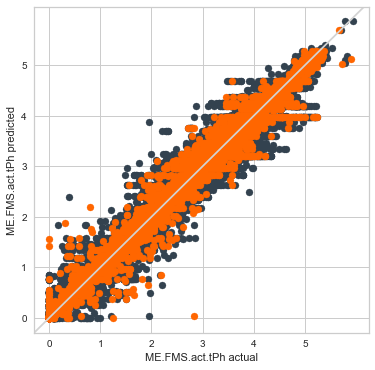

In [32]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
plt.xticks(np.arange(0,6,1));
plt.yticks(np.arange(0,6,1));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");

### Write to MLFlow

In [65]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "features drop": 'According to model importance list',
      "random_state": 42,
      "max_depth": 10,
      "csv used": 'Featureselection03.csv',
      "NaN handling": 'V.SLPOG.act.PRC and ME.SFCI.act.gPkWh filled with 0, rest dropped by row',
      'Shape' : df.shape,
      'Scaler' : 'MinMaxScaler'
  }

In [66]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "RMSE", rmse_train)
mlflow.log_metric("test-" + "RMSE", rmse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

## Modelling (Grid Search)

### Pipeline

In [33]:
tree4 = make_pipeline(MinMaxScaler(), DecisionTreeRegressor())

### Grid Search

In [34]:
# Grid search for Decision Tree

# Defining parameter grid (as dictionary)
param_grid = {'decisiontreeregressor__criterion':['squared_error', 'friedman_mse', 'poisson'],
              'decisiontreeregressor__splitter':['best','random'],
              'decisiontreeregressor__max_depth':[3,5,10,15],
              'decisiontreeregressor__min_samples_split':[5,10,50,100],
              'decisiontreeregressor__max_features':['auto'],
              'decisiontreeregressor__max_leaf_nodes':[10,50,100,500],
              'decisiontreeregressor__random_state': [42]
             }

# Instantiate gridsearch and define the metric to optimize 
gs_tree = GridSearchCV(tree4, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=2, n_jobs=-1)

### Fit and predict

In [35]:
gs_tree.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END decisiontreeregressor__criterion=squared_error, decisiontreeregressor__max_depth=3, decisiontreeregressor__max_features=auto, decisiontreeregressor__max_leaf_nodes=10, decisiontreeregressor__min_samples_split=5, decisiontreeregressor__random_state=42, decisiontreeregressor__splitter=random; total time=   0.9s
[CV] END decisiontreeregressor__criterion=squared_error, decisiontreeregressor__max_depth=3, decisiontreeregressor__max_features=auto, decisiontreeregressor__max_leaf_nodes=10, decisiontreeregressor__min_samples_split=5, decisiontreeregressor__random_state=42, decisiontreeregressor__splitter=random; total time=   1.0s
[CV] END decisiontreeregressor__criterion=squared_error, decisiontreeregressor__max_depth=3, decisiontreeregressor__max_features=auto, decisiontreeregressor__max_leaf_nodes=10, decisiontreeregressor__min_samples_split=5, decisiontreeregressor__random_state=42, decisiontreeregressor__splitter=ran

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'decisiontreeregressor__criterion': ['squared_error',
                                                              'friedman_mse',
                                                              'poisson'],
                         'decisiontreeregressor__max_depth': [3, 5, 10, 15],
                         'decisiontreeregressor__max_features': ['auto'],
                         'decisiontreeregressor__max_leaf_nodes': [10, 50, 100,
                                                                   500],
                         'decisiontreeregressor__min_samples_split': [5, 10, 50,
                                                                      100],
                         'decisiontreeregressor__random_sta

In [36]:
# Show best parameters
print('Best score:\n{:.2f}'.format(gs_tree.best_score_))
print("Best parameters:\n{}".format(gs_tree.best_params_))

Best score:
-0.11
Best parameters:
{'decisiontreeregressor__criterion': 'friedman_mse', 'decisiontreeregressor__max_depth': 15, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__max_leaf_nodes': 500, 'decisiontreeregressor__min_samples_split': 10, 'decisiontreeregressor__random_state': 42, 'decisiontreeregressor__splitter': 'best'}


In [37]:
y_pred = gs_tree.predict(X_test)
y_pred_train = gs_tree.predict(X_train)

### RMSE

In [38]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.09467785454233418
RMSE test:  0.10921370935866254


### Plot

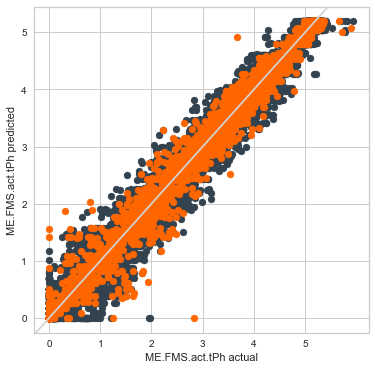

In [39]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
plt.xticks(np.arange(0,6,1));
plt.yticks(np.arange(0,6,1));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");

### Write to MLFlow

In [103]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "features drop": 'According to model importance list',
      "criterion": 'squared_error',
      'max_features': 'auto',
      "random_state": 42,
      "max_depth": 15,
      'max_leaf_nodes': 500,
      'min_samples_split': 10,
      'splitter': 'best',
      "csv used": 'Featureselection03.csv',
      "NaN handling": 'V.SLPOG.act.PRC and ME.SFCI.act.gPkWh filled with 0, rest dropped by row',
      'Shape' : df.shape,
      'Scaler' : 'MinMaxScaler'
  }

In [104]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "RMSE", rmse_train)
mlflow.log_metric("test-" + "RMSE", rmse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

## Modelling (Grid Search, fine tuning)

### Pipeline

In [40]:
tree5 = make_pipeline(MinMaxScaler(), DecisionTreeRegressor())

### Grid Search

In [41]:
# Grid search for Decision Tree

# Defining parameter grid (as dictionary)
param_grid2 = {'decisiontreeregressor__criterion':['squared_error'],
              'decisiontreeregressor__splitter':['best'],
              'decisiontreeregressor__max_depth':[15,20,30,50],
              'decisiontreeregressor__min_samples_split':[7,10,15,20],
              'decisiontreeregressor__max_features':['auto'],
              'decisiontreeregressor__max_leaf_nodes':[500,1000,2000,5000],
              'decisiontreeregressor__random_state': [42]
             }

# Instantiate gridsearch and define the metric to optimize 
gs_tree2 = GridSearchCV(tree5, param_grid2, scoring='neg_root_mean_squared_error', cv=5, verbose=2, n_jobs=-1)

### Fit and predict

In [42]:
gs_tree2.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END decisiontreeregressor__criterion=squared_error, decisiontreeregressor__max_depth=15, decisiontreeregressor__max_features=auto, decisiontreeregressor__max_leaf_nodes=500, decisiontreeregressor__min_samples_split=7, decisiontreeregressor__random_state=42, decisiontreeregressor__splitter=best; total time=   7.2s
[CV] END decisiontreeregressor__criterion=squared_error, decisiontreeregressor__max_depth=15, decisiontreeregressor__max_features=auto, decisiontreeregressor__max_leaf_nodes=500, decisiontreeregressor__min_samples_split=7, decisiontreeregressor__random_state=42, decisiontreeregressor__splitter=best; total time=   7.3s
[CV] END decisiontreeregressor__criterion=squared_error, decisiontreeregressor__max_depth=15, decisiontreeregressor__max_features=auto, decisiontreeregressor__max_leaf_nodes=500, decisiontreeregressor__min_samples_split=7, decisiontreeregressor__random_state=42, decisiontreeregressor__splitter=bes

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'decisiontreeregressor__criterion': ['squared_error'],
                         'decisiontreeregressor__max_depth': [15, 20, 30, 50],
                         'decisiontreeregressor__max_features': ['auto'],
                         'decisiontreeregressor__max_leaf_nodes': [500, 1000,
                                                                   2000, 5000],
                         'decisiontreeregressor__min_samples_split': [7, 10, 15,
                                                                      20],
                         'decisiontreeregressor__random_state': [42],
                         'decisiontreeregressor__splitter': ['best']},
             scoring='neg_root_mean_squared_error', verbose=2)

In [43]:
# Show best parameters
print('Best score:\n{:.2f}'.format(gs_tree2.best_score_))
print("Best parameters:\n{}".format(gs_tree2.best_params_))

Best score:
-0.10
Best parameters:
{'decisiontreeregressor__criterion': 'squared_error', 'decisiontreeregressor__max_depth': 30, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__max_leaf_nodes': 2000, 'decisiontreeregressor__min_samples_split': 20, 'decisiontreeregressor__random_state': 42, 'decisiontreeregressor__splitter': 'best'}


In [44]:
y_pred = gs_tree2.predict(X_test)
y_pred_train = gs_tree2.predict(X_train)

### RMSE

In [45]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.06443902089752557
RMSE test:  0.0920400930581957


### Plot

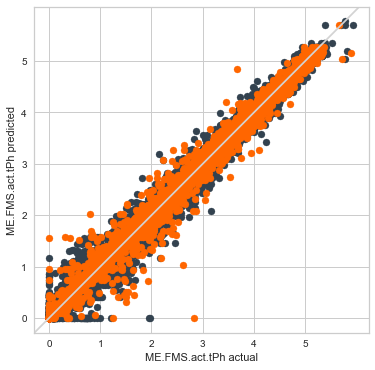

In [46]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
plt.xticks(np.arange(0,6,1));
plt.yticks(np.arange(0,6,1));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");

/Users/rweil/neue_fische/capstone_ml_shipping/.venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


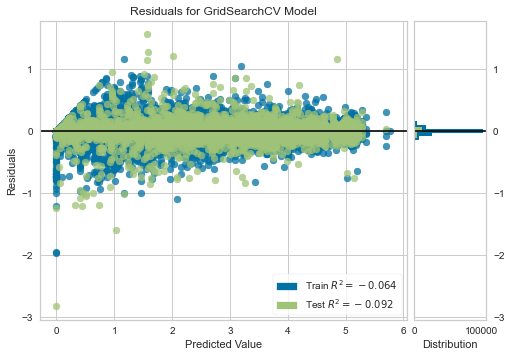

<AxesSubplot:title={'center':'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [47]:
visualizer = ResidualsPlot(gs_tree2)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

## Modelling (final Regression Tree)
Best parameters:
{'decisiontreeregressor__criterion': 'squared_error', 'decisiontreeregressor__max_depth': 30, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__max_leaf_nodes': 2000, 'decisiontreeregressor__min_samples_split': 20, 'decisiontreeregressor__random_state': 42, 'decisiontreeregressor__splitter': 'best'}

### Pipeline

In [48]:
tree_final = make_pipeline(MinMaxScaler(), 
                DecisionTreeRegressor(criterion= 'squared_error', 
                                        max_depth= 30, 
                                        max_features= 'auto',
                                        max_leaf_nodes= 2000, 
                                        min_samples_split= 20, 
                                        random_state= 42, 
                                        splitter= 'best'))

### Fit and predict

In [49]:
tree_final.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=30, max_features='auto',
                                       max_leaf_nodes=2000,
                                       min_samples_split=20,
                                       random_state=42))])

In [50]:
y_pred = tree_final.predict(X_test)
y_pred_train = tree_final.predict(X_train)

### RMSE

In [51]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.06443902089752557
RMSE test:  0.0920400930581957


### Plot

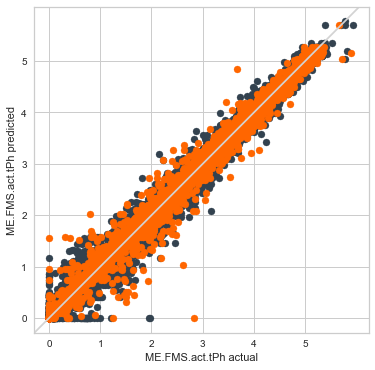

In [52]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
plt.xticks(np.arange(0,6,1));
plt.yticks(np.arange(0,6,1));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");

/Users/rweil/neue_fische/capstone_ml_shipping/.venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


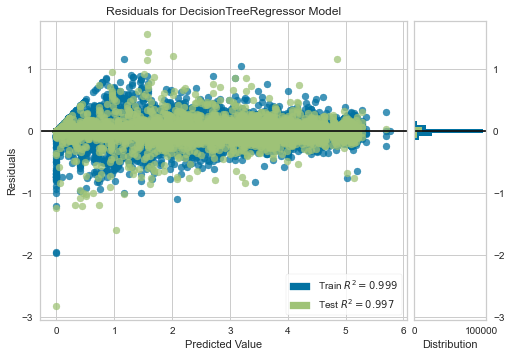

<AxesSubplot:title={'center':'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [53]:
visualizer = ResidualsPlot(tree_final)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 

### Write to MLFlow

In [135]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "features drop": 'According to model importance list',
      "criterion": 'squared_error',
      'max_features': 'auto',
      "random_state": 42,
      "max_depth": 30,
      'max_leaf_nodes': 2000,
      'min_samples_split': 10,
      'splitter': 'best',
      "csv used": 'Featureselection03.csv',
      "NaN handling": 'V.SLPOG.act.PRC and ME.SFCI.act.gPkWh filled with 0, rest dropped by row',
      'Shape' : df.shape,
      'Scaler' : 'MinMaxScaler'
  }

In [136]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "RMSE", rmse_train)
mlflow.log_metric("test-" + "RMSE", rmse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()